In [1]:
from __future__ import print_function
import sys
import os
import pandas as pd
import csv
import seaborn as sns
import time
import matplotlib.pyplot as plt
import alphastats
import warnings
import numpy as np
warnings.filterwarnings("ignore", category=UserWarning, module="openpyxl") # remove warning from mac
import plotly.io as pio
pio.renderers.default = "plotly_mimetype+notebook" 
from IPython.display import display, HTML, Markdown
display(HTML("<style>:root { --jp-notebook-max-width: 80% !important; }</style>"))
from sklearn.utils._openmp_helpers import _openmp_effective_n_threads, _openmp_parallelism_enabled
_openmp_effective_n_threads(6)

plt.rcParams['pdf.fonttype'] = 42 

os.environ.setdefault("TF_NUM_THREADS", "10")
os.environ.setdefault("TF_LOOP_PARALLEL_ITERATIONS", "10")

'10'

/Users/magalhae/miniforge3/envs/alphastats/lib/python3.10/site-packages/outdated/utils.py:14: OutdatedPackageWarning:

The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.



In [2]:
import plotly

colorway=["#B80000", "#E81E63", "#8D239E", "#673AB7", "#3F51B5", "#253985", "#02A8F4", "#009688", "#8BC34A", "#FF9800", "#FE5622", "#795648", "#9E9E9E", "#617D8B",]

plotly.io.templates["alphastats_colors"] = plotly.graph_objects.layout.Template(
    layout=plotly.graph_objects.Layout(
        paper_bgcolor="rgba(0,0,0,0)",
        plot_bgcolor="rgba(0,0,0,0)",
        colorway=colorway
        ,
    )
)
plotly.io.templates.default = "simple_white+alphastats_colors"

display(Markdown('<br>'.join(
    f'<span style="font-family: monospace">{color} <span style="color: {color}">████████</span></span>'
    for color in colorway
)))
len(colorway)

<span style="font-family: monospace">#B80000 <span style="color: #B80000">████████</span></span><br><span style="font-family: monospace">#E81E63 <span style="color: #E81E63">████████</span></span><br><span style="font-family: monospace">#8D239E <span style="color: #8D239E">████████</span></span><br><span style="font-family: monospace">#673AB7 <span style="color: #673AB7">████████</span></span><br><span style="font-family: monospace">#3F51B5 <span style="color: #3F51B5">████████</span></span><br><span style="font-family: monospace">#253985 <span style="color: #253985">████████</span></span><br><span style="font-family: monospace">#02A8F4 <span style="color: #02A8F4">████████</span></span><br><span style="font-family: monospace">#009688 <span style="color: #009688">████████</span></span><br><span style="font-family: monospace">#8BC34A <span style="color: #8BC34A">████████</span></span><br><span style="font-family: monospace">#FF9800 <span style="color: #FF9800">████████</span></span><br><span style="font-family: monospace">#FE5622 <span style="color: #FE5622">████████</span></span><br><span style="font-family: monospace">#795648 <span style="color: #795648">████████</span></span><br><span style="font-family: monospace">#9E9E9E <span style="color: #9E9E9E">████████</span></span><br><span style="font-family: monospace">#617D8B <span style="color: #617D8B">████████</span></span>

14

In [3]:
Andersen2005 = pd.read_csv('/Users/magalhae/Desktop/FANCY_proteome/NucleolusList/Andersen2005_idmapping_active_true_2024_08_28.tsv',low_memory=False, sep = '\t')
SubCellBarcode = pd.read_csv('/Users/magalhae/Desktop/FANCY_proteome/NucleolusList/SubCell_markerProteins_annotated.csv',low_memory=False)
Stenstrom2020 = pd.read_excel('/Users/magalhae/Desktop/FANCY_proteome/NucleolusList/msb209469-sup-0002-datasetev1.xlsx', sheet_name=1)
Stenstrom2020 = Stenstrom2020[~Stenstrom2020['Uniprot ID'].isna()]
Andersen2005.info()
SubCellBarcode.info()
Stenstrom2020.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 810 entries, 0 to 809
Data columns (total 11 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   From                                810 non-null    object
 1   Entry                               810 non-null    object
 2   Reviewed                            810 non-null    object
 3   Entry Name                          810 non-null    object
 4   Protein names                       810 non-null    object
 5   Gene Names                          796 non-null    object
 6   GeneID                              787 non-null    object
 7   Ensembl                             765 non-null    object
 8   Gene Ontology (molecular function)  781 non-null    object
 9   Gene Ontology (biological process)  777 non-null    object
 10  Gene Ontology (cellular component)  800 non-null    object
dtypes: object(11)
memory usage: 69.7+ KB
<class 'pandas.core.f

In [3]:
ProteinGroups = pd.read_csv('.././proteinGroups.txt',low_memory=False, sep = '\t')
# ProteinGroups = ProteinGroups.set_index('Protein IDs')
ProteinGroups.info()
ProteinGroups = ProteinGroups[~ProteinGroups['Protein IDs'].str.contains("CON_")]
ProteinGroups = ProteinGroups[~ProteinGroups['Protein IDs'].str.contains("REV__")]
ProteinGroups.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4002 entries, 0 to 4001
Columns: 474 entries, Protein IDs to Taxonomy names
dtypes: float64(202), int64(201), object(71)
memory usage: 14.5+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 3813 entries, 0 to 3945
Columns: 474 entries, Protein IDs to Taxonomy names
dtypes: float64(202), int64(201), object(71)
memory usage: 13.8+ MB


In [4]:
ProteinGroups = ProteinGroups[[col for col in ProteinGroups.columns if "input" not in col]]

In [5]:
maxquant_data = alphastats.MaxQuantLoader(ProteinGroups)
# maxquant_data = alphastats.MaxQuantLoader(file="proteinGroups.txt")
ds = alphastats.DataSet(
    loader = maxquant_data,
    metadata_path="Metadata_wo_Input.csv", 
    sample_column="sample"
)
print(f"Number of samples in the matrix: {ds.mat.shape[0]}, number of samples in metadata: {ds.metadata.shape[0]}.")

DataSet has been created.
Attributes of the DataSet can be accessed using: 
DataSet.rawinput:	 Raw Protein data.
DataSet.mat:		Processed data matrix with ProteinIDs/ProteinGroups as columns and samples as rows. All computations are performed on this matrix.
DataSet.metadata:	Metadata for the samples in the matrix. Metadata will be matched with DataSet.mat when needed (for instance Volcano Plot).
Number of samples in the matrix: 24, number of samples in metadata: 14.


In [6]:
ds.mat.replace(0, np.nan, inplace=True)

In [7]:
#ds.preprocess(subset = True, log2_transform =False,remove_contaminations=True)
ds.preprocess(subset = True, log2_transform =True)

Data has been log2-transformed.


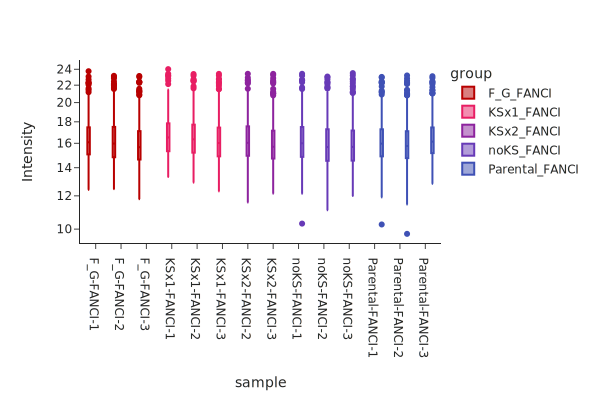

In [10]:
plot = ds.plot_sampledistribution(method = "box", color = "group", log_scale = True)
plot.show(renderer = "svg", width=600, height=400)
plot.write_image("sampledistribution.pdf")

In [11]:
ds.preprocess_print_info()

                                                    0  \
0                   Raw data number of Protein Groups   
1          Matrix: Number of ProteinIDs/ProteinGroups   
2                           Matrix: Number of samples   
3                         Intensity used for analysis   
4                                    Log2-transformed   
5                                       Normalization   
6                                          Imputation   
7                    Contaminations have been removed   
8                               Contamination columns   
9   Number of removed ProteinGroups due to contami...   
10                          Data completeness cut-off   

                                                    1  
0                                                1333  
1                                                1333  
2                                                  14  
3                              LFQ intensity [sample]  
4                                  

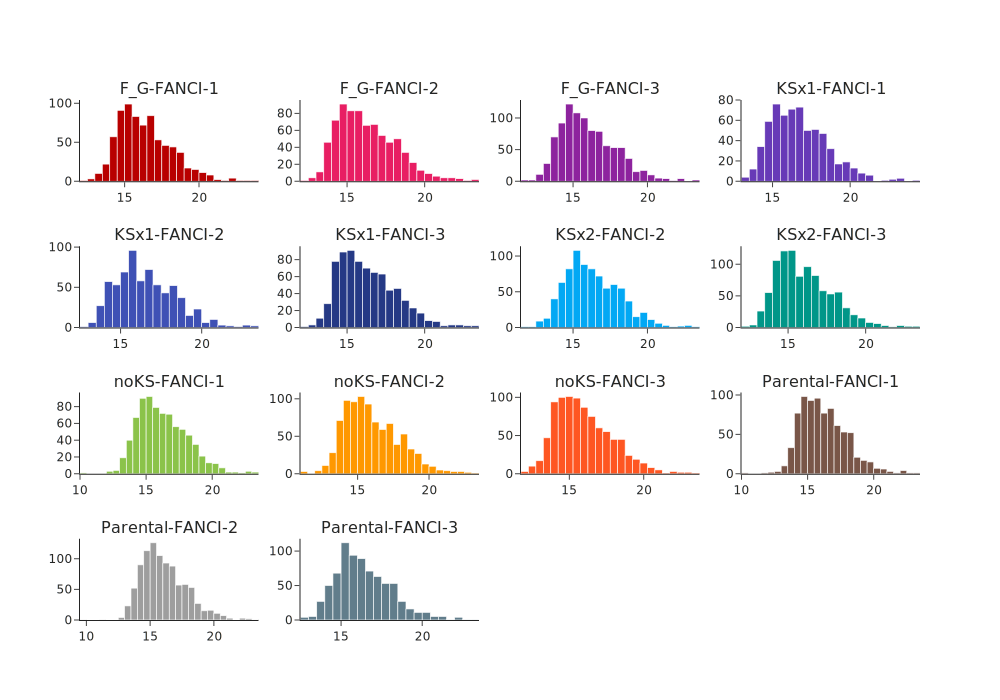

In [12]:
plot = ds.plot_samplehistograms()
plot.show(renderer = "svg", width=1000, height=700)
plot.write_image("samplehistograms.pdf")

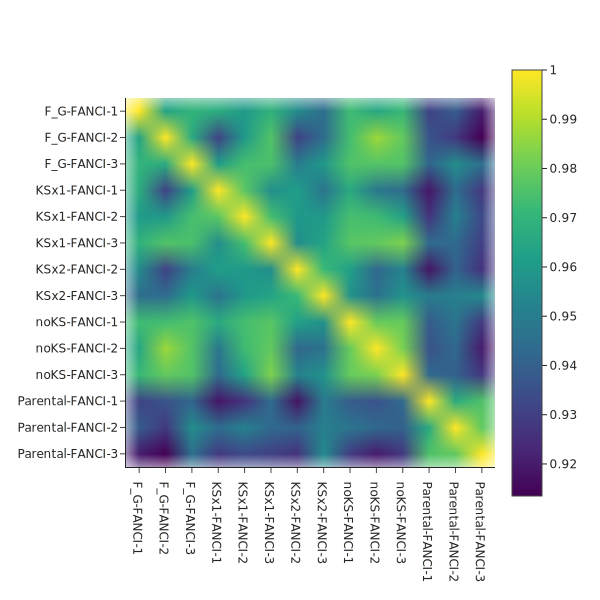

In [13]:
plot = ds.plot_correlation_matrix(method = "pearson")
plot.show(renderer = "svg", width=600, height=600)
plot.write_image("cluster_before_Norm.pdf")

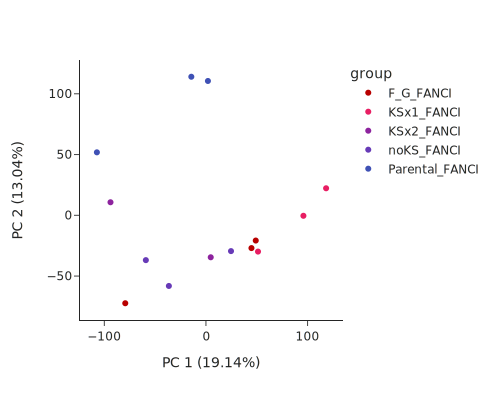

In [14]:
# ds.mat = np.log10(ds.mat + 1)
plot = ds.plot_pca(group = "group", circle = False)
plot.show(renderer = "svg", width=500, height=400, equal_axes=True)
plot.write_image("PCA_all.pdf")

In [8]:
ds.reset_preprocessing()

All preprocessing steps are reset.


In [15]:
np.log2(ds.rawmat['Q6NW34;Q6NW34-2']+1)

ActD-FANCI-1        13.396337
ActD-FANCI-2         0.000000
ActD-FANCI-3         0.000000
ActD-FANCI-4        13.032425
F_G-FANCI-1         14.024187
F_G-FANCI-2         14.119184
F_G-FANCI-3         13.866410
F_G-FANCI-4         13.913357
KSx1-FANCI-1         0.000000
KSx1-FANCI-2         0.000000
KSx1-FANCI-3         0.000000
KSx1-FANCI-4        12.768453
KSx2-FANCI-1         0.000000
KSx2-FANCI-2        13.225659
KSx2-FANCI-3         0.000000
KSx2-FANCI-4        12.771118
noKS-FANCI-1        13.764146
noKS-FANCI-2        14.109586
noKS-FANCI-3        13.881210
noKS-FANCI-4        13.557823
Parental-FANCI-1    13.585549
Parental-FANCI-2    13.756139
Parental-FANCI-3    13.100597
Parental-FANCI-4    13.592340
Name: Q6NW34;Q6NW34-2, dtype: float64

In [9]:
start = time.time()
ds.reset_preprocessing()
#ds.mat.replace(0, np.nan, inplace=True)
ds.preprocess(
    subset = True,
    remove_contaminations=True,
    log2_transform =True,
    normalization = None,
    #normalization = 'vst',
    imputation = None
)
from numpy import inf
ds.mat[ds.mat == -inf] = 0
end = time.time()
print(end - start)

All preprocessing steps are reset.
Data has been log2-transformed.
0.022250890731811523


In [42]:
ds.mat['Q6NW34;Q6NW34-2']

F_G-FANCI-1         14.024101
F_G-FANCI-2         14.119103
F_G-FANCI-3         13.866313
F_G-FANCI-4         13.913263
KSx1-FANCI-1         0.000000
KSx1-FANCI-2         0.000000
KSx1-FANCI-3         0.000000
KSx2-FANCI-2        13.225509
KSx2-FANCI-3         0.000000
noKS-FANCI-1        13.764042
noKS-FANCI-2        14.109504
noKS-FANCI-3        13.881114
noKS-FANCI-4        13.557703
Parental-FANCI-1    13.585432
Parental-FANCI-2    13.756035
Parental-FANCI-3    13.100432
Parental-FANCI-4    13.592223
Name: Q6NW34;Q6NW34-2, dtype: float64

In [28]:
ds.mat['O75683']

F_G-FANCI-1         18.199308
F_G-FANCI-2         17.988319
F_G-FANCI-3         18.199500
KSx1-FANCI-1        18.388942
KSx1-FANCI-2        18.242700
KSx1-FANCI-3        17.967136
KSx2-FANCI-2        18.180201
KSx2-FANCI-3        17.844877
noKS-FANCI-1        18.201942
noKS-FANCI-2        18.173628
noKS-FANCI-3        18.096972
Parental-FANCI-1    17.689002
Parental-FANCI-2    17.750550
Parental-FANCI-3    17.772753
Name: O75683, dtype: float64

In [85]:
ds.mat['Q07020;Q07020-2']

F_G-FANCI-1         16.874357
F_G-FANCI-2         16.954355
F_G-FANCI-3         16.122585
F_G-FANCI-4         16.647936
KSx1-FANCI-1        17.000968
KSx1-FANCI-2        16.900655
KSx1-FANCI-3        16.843406
KSx2-FANCI-2        17.136511
KSx2-FANCI-3        16.553569
noKS-FANCI-1        17.162313
noKS-FANCI-2        17.112786
noKS-FANCI-3        17.016068
noKS-FANCI-4        17.497010
Parental-FANCI-1    16.866289
Parental-FANCI-2    16.750419
Parental-FANCI-3    16.525781
Parental-FANCI-4    16.199653
Name: Q07020;Q07020-2, dtype: float64

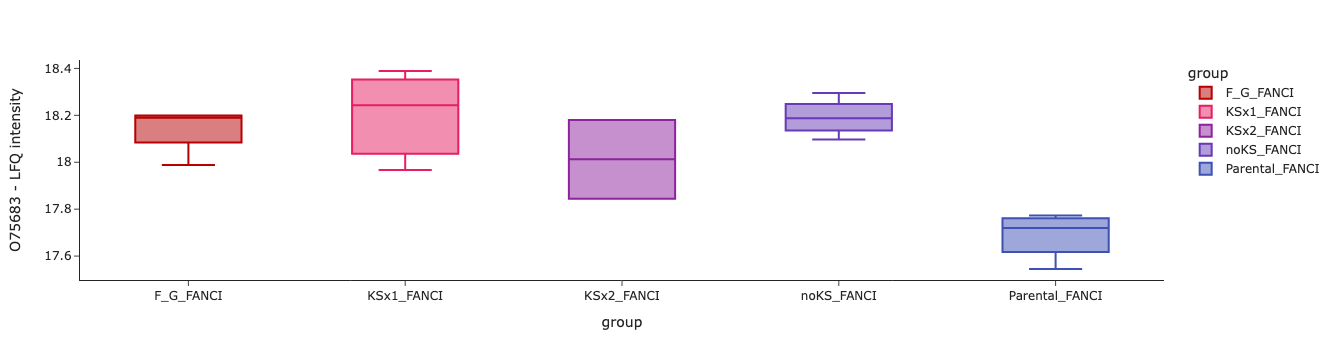

In [82]:
ds.plot_intensity("O75683", group = "group")

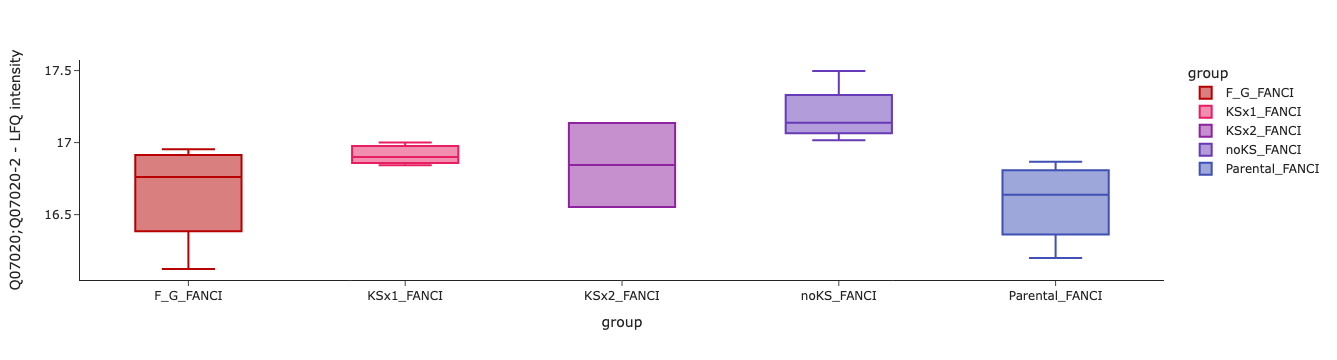

In [84]:
ds.plot_intensity('Q07020;Q07020-2', group = "group")

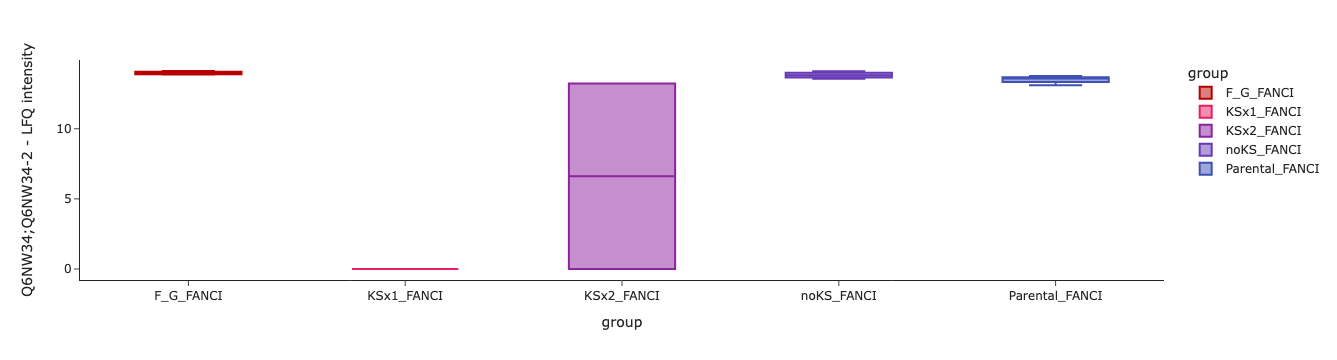

In [80]:
ds.plot_intensity("Q6NW34;Q6NW34-2", group = "group")

In [91]:
import pickle 
with open('NucleolarProt_quantile_20241210.pickle', 'wb') as output:
    pickle.dump(ds, output)

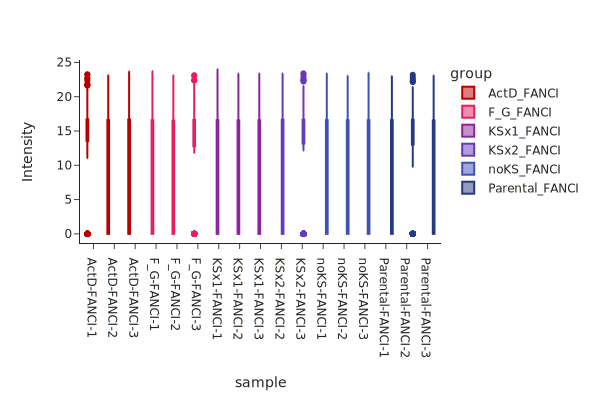

In [92]:
plot = ds.plot_sampledistribution(method = "box", color = "group", log_scale = False)
plot.show(renderer = "svg", width=600, height=400)
plot.write_image("sample_Dist_norm.pdf")

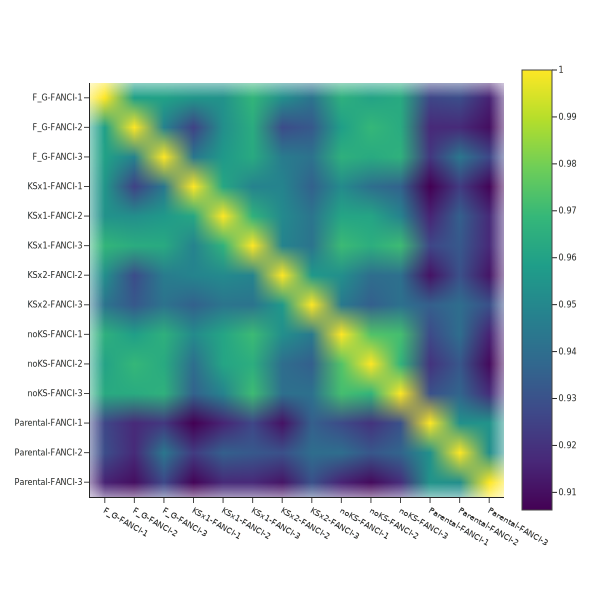

In [222]:
plot = ds.plot_correlation_matrix(method = "pearson")
plot.update_layout(font=dict(size=8))
plot.show(renderer = "svg", width=600, height=600)
plot.write_image("correlation_matrix_after_svd_quantile.pdf")

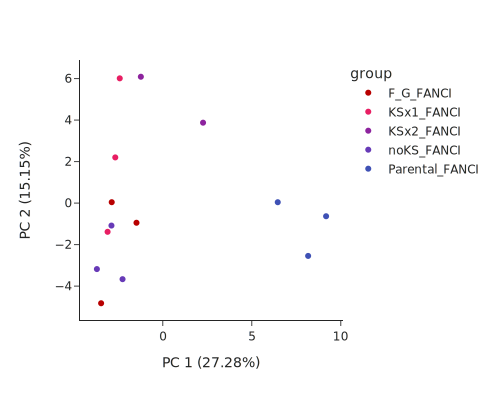

In [223]:
plot = ds.plot_pca(group = "group", circle = False)
plot.show(renderer = "svg", width=500, height=400, equal_axes=True)
plot.write_image("PCA_norm_all.pdf")

In [56]:
import plotly
from alphastats.plots.PlotUtils import PlotUtils, plotly_object
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce

import scipy
from scipy.spatial import distance
from scipy.cluster import hierarchy
import sklearn
from sklearn.metrics import silhouette_score
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph

np.random.seed(12345)

In [29]:
def element_exists(lst, element):
  # Try to get the index of the element in the list
  try:
    lst.index(element)
  # If the element is found, return True
    return True
  # If a ValueError is raised, the element is not in the list
  except ValueError:
  # Return False in this case
    return False

In [114]:
# anova on ds to remove genes that dont change
anova_df = ds.anova(column="group", tukey=False)
# saev anova results
anova_df.to_csv('anova_df_Tukey_alphastats_processed_quantile_svd.csv', index=True)

# reset the index and use
anova_df = anova_df.set_index('Protein IDs')

# anova_df =  pd.read_csv('anova_df_Tukey_alphastats_processed_quantile_svd.csv',low_memory=False)
# significant_proteins = anova_df[anova_df["Protein IDs"]][ds.index_column].to_list()

In [115]:
# anova_df =  pd.read_csv('./Heatmap/anova_df_Tukey_alphastats_processed_quantile_svd.csv',low_memory=False).set_index('Protein IDs')
significant_proteins = anova_df[anova_df["ANOVA_pvalue"] < 0.05].index.to_list()
significant_proteins.append("mCherry") if "mCherry" not in significant_proteins else significant_proteins
significant_proteins_df = pd.DataFrame(significant_proteins, columns=["Protein IDs"]).to_csv('significat_proteins_anova.csv', index=False)

In [116]:
len(significant_proteins)

505

In [43]:
df = ds.mat
df = pd.DataFrame(df).T
# set the desired order of groups
groups = [ "Parental-FANCI-1", "Parental-FANCI-2", "Parental-FANCI-3",
          "noKS-FANCI-1", "noKS-FANCI-2", "noKS-FANCI-3",
          "KSx1-FANCI-1", "KSx1-FANCI-2", "KSx1-FANCI-3",
          "KSx2-FANCI-2", "KSx2-FANCI-3",
          "F_G-FANCI-1", "F_G-FANCI-2", "F_G-FANCI-3"
          ]


# reorder indexes/indices besed on the desired order
new_order = []
for group in groups:
    indexes = df.columns.str.startswith(group)
    indexes_locs = np.where(indexes)[0].tolist()
    new_order += indexes_locs

## reorder df based on the new order\
ordered_df = df.iloc[:, new_order]

#ordered_df = ordered_df.loc[ordered_df.index.isin(significant_proteins)]

In [44]:
len(groups)

14

In [45]:
print(df.shape)
print(ordered_df.shape)

(1333, 14)
(1333, 14)


In [46]:
ordered_df = ordered_df.reset_index()
ordered_df['Andersen2005'] = ordered_df['Protein IDs'].apply(lambda x: any(i in x for i in Andersen2005['Entry']))
ordered_df['SubCellBarcode'] = ordered_df['Protein IDs'].apply(lambda x: any(i in x for i in SubCellBarcode[SubCellBarcode['Compartments']=="N3"]['ProteinID']))
ordered_df['SubCellBarcode_N'] = ordered_df['Protein IDs'].apply(lambda x: any(i in x for i in SubCellBarcode[SubCellBarcode['Compartments'].isin(['N1','N2','N3', 'N4'])]['ProteinID']))
ordered_df['Stenstrom2020'] = ordered_df['Protein IDs'].apply(lambda x: any(i in x for i in set(Stenstrom2020['Uniprot ID'])))
ordered_df = ordered_df.set_index('Protein IDs')

In [47]:
len(Stenstrom2020['Uniprot ID'].unique())

1292

In [48]:
print(ordered_df.Andersen2005.value_counts())
print(ordered_df.SubCellBarcode.value_counts())
print(ordered_df.Stenstrom2020.value_counts())
print(ordered_df.SubCellBarcode_N.value_counts())

Andersen2005
False    806
True     527
Name: count, dtype: int64
SubCellBarcode
False    1177
True      156
Name: count, dtype: int64
Stenstrom2020
False    1044
True      289
Name: count, dtype: int64
SubCellBarcode_N
False    928
True     405
Name: count, dtype: int64


In [49]:
def search(regex: str, df, case=False):
    """Search all the text columns of `df`, return rows with any matches."""
    textlikes = df.select_dtypes(include=[object, "string"])
    return df[
        textlikes.apply(
            lambda column: column.str.contains(regex, regex=True, case=case, na=False)
        ).any(axis=1)
    ]

In [50]:
Anderson2005_df = ordered_df.pop("Andersen2005")
SubCellBarcode_df = ordered_df.pop("SubCellBarcode")
SubCellBarcode_N_df = ordered_df.pop("SubCellBarcode_N")
Stenstrom2020_df = ordered_df.pop("Stenstrom2020")

In [51]:
metadata = ds.metadata
metadata = metadata.set_index('sample')

In [52]:
ordered_df

,Parental-FANCI-1,Parental-FANCI-2,Parental-FANCI-3,noKS-FANCI-1,noKS-FANCI-2,noKS-FANCI-3,KSx1-FANCI-1,KSx1-FANCI-2,KSx1-FANCI-3,KSx2-FANCI-2,KSx2-FANCI-3,F_G-FANCI-1,F_G-FANCI-2,F_G-FANCI-3
Protein IDs,,,,,,,,,,,,,,
Q9Y2S6;A0A024R1R8,15.351077,0.000000,0.000000,15.223398,15.595607,15.819106,0.000000,14.689507,15.058499,0.000000,15.134827,0.000000,14.995988,15.129726
A0MZ66;A0MZ66-3;A0MZ66-4;A0MZ66-5;A0MZ66-6;A0MZ66-8;A0MZ66-2;A0MZ66-7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,13.876037,13.981032,13.482682,0.000000,0.000000
P62308;A8MWD9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,15.682748,0.000000,0.000000,0.000000,14.935764
E9PAV3;Q13765;E9PAV3-2,14.688414,15.296414,15.126099,14.888172,15.432118,15.223587,15.501993,15.411577,15.235042,15.907806,15.686501,14.741046,14.573055,15.117968
E9PRG8,15.689425,15.875077,15.722594,16.334256,16.366288,15.884767,16.522536,16.137031,15.744650,16.044181,15.853163,16.156063,15.819880,16.318472
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q9Y5J1,16.293166,16.777641,16.471723,17.049104,17.208387,16.873636,17.024642,17.402746,17.100621,17.149172,17.004923,16.880468,17.257185,17.033488
Q9Y5Q9;Q9Y5Q9-2,0.000000,14.295338,14.352595,14.529980,14.357140,13.997268,0.000000,14.872915,14.418182,14.684639,14.697619,14.512308,14.771747,14.731584
Q9Y5S9;Q9Y5S9-2,16.714111,17.095170,17.025507,16.419104,16.341936,16.552384,15.956966,15.999582,16.181366,17.128981,16.970735,16.249595,16.175822,16.676728


In [39]:
df.dropna(how = 'all', inplace=True)


In [40]:
df = df.loc[(df.sum(axis=1) != 0)]

In [41]:
np.quantile(ordered_df, 0.95)

18.916270032313147

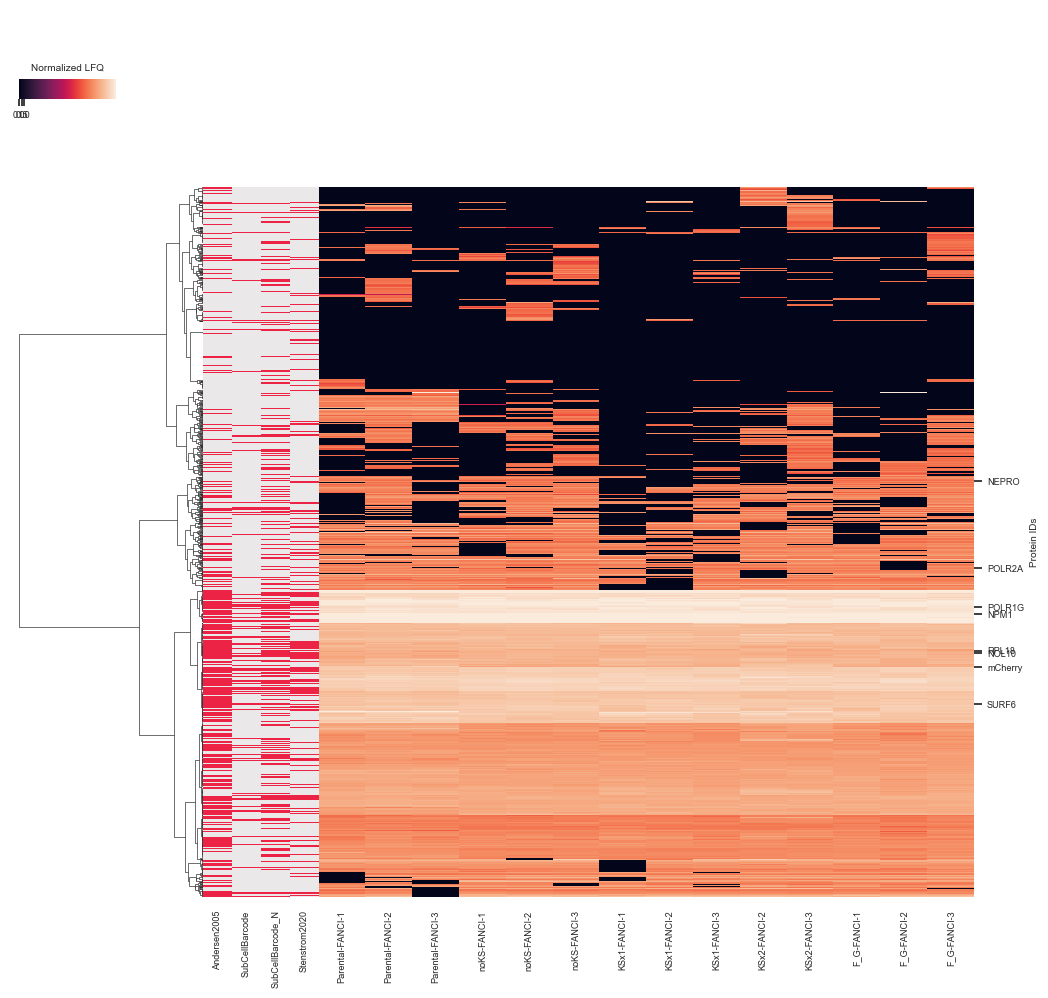

In [53]:
### Display some proteins

sns.set(font_scale=0.6)

lut1 = dict(zip(Anderson2005_df.unique(), ['#ed2345','#ebe8e9']))
row_colors1 = Anderson2005_df.map(lut1)

lut2 = dict(zip(SubCellBarcode_df.unique(), ['#ebe8e9','#ed2345']))
row_colors2 = SubCellBarcode_df.map(lut2)

lut3 = dict(zip(SubCellBarcode_N_df.unique(), ['#ebe8e9','#ed2345']))
row_colors3 = SubCellBarcode_N_df.map(lut3)

lut4 = dict(zip(Stenstrom2020_df.unique(), ['#ed2345','#ebe8e9']))
row_colors4 = Stenstrom2020_df.map(lut1)

row_colors = pd.concat([row_colors1,row_colors2,row_colors3,row_colors4],axis=1)


heat_clust = sns.clustermap(ordered_df,
                            col_cluster=False,
                            yticklabels=False,
                            method='ward',
                            cmap="rocket",
                            row_colors=row_colors,
                            #z_score=0,
                            #cmap="coolwarm",
                            #cmap="icefire",
                            #cmap="RdPu",
                            #cmap="mako",
                            #cmap="YlGnBu",
                            #cmap=sns.diverging_palette(220, 20, as_cmap=True),
                            #cmap="RdYlBu_r",
                            #center=0,
                            #mask=(ordered_df==0),
                            vmin=0,
                            vmax=20,
                            cbar_kws=dict(
                                ticks=[0,0.5, 1],
                                #ticks=[-2,0, 2],
                                orientation="horizontal",
                                
                            )
                           )

x0, _y0, _w, _h = heat_clust.cbar_pos
heat_clust.ax_cbar.set_position([x0,
                                 0.9,
                                 heat_clust.ax_row_dendrogram.get_position().width/2,
                                 0.02]
                               )
heat_clust.ax_cbar.set_title('Normalized LFQ')
heat_clust.ax_cbar.tick_params(axis='x',
                               length=5)


reordered_labels = ordered_df.index[heat_clust.dendrogram_row.reordered_ind].tolist()
use_labels = []



use_labels = ['msfGFP-NPM1', 'mCherry', 
              'Q6NW34', #NEPRO
              'Q9BSC4', #NOL10
              'O15446', #POLR1G
              'Q9P1U0', #POLR1H
              'P24928', #POLR2A
              'O75683', #SURF6
              'Q07020;Q07020-2' #RPL18

              # #NEPRO Super-complex
              # # "O95059", #RPP14
              # # "Q9BUL9", #RPP25
              # "P78345", #RPP38
              # # "O75818", #RPP40
              # "P78346", #RPP30
              # # "Q32NC0", #C18orf21
              # "O95707", #POP4(RPP29)
              # "O75817", #POP7(RPP20)
              # # "Q969H6", #POP5
              # #Interactor of POP7 and RPP25L
              # "Q9P2D0", #IBTK
              # #Interactor of NPM1 and RPP25L
              # "Q8N5L8", #RPP25L
             ]

use_labels_correct = []
use_labels_g = []
use_labels_c = []
for labels in use_labels:
    use_labels_correct.append(search(labels, ds.rawinput, case=False)['Protein IDs'].values[0])

for labels in use_labels_correct:
    if labels in reordered_labels:
        use_labels_c.append(labels)
        use_labels_g.append(ds.rawinput.set_index('Protein IDs').loc[[labels], "Gene names"].values[0].split(";")[0])
    else: continue


use_ticks = [reordered_labels.index(label) + .5 for label in use_labels_c]

heat_clust.ax_heatmap.set(yticks=use_ticks, yticklabels=use_labels_g)




heat_clust.fig.set_size_inches((10,10))
heat_clust.savefig("Heatmap_clustered_filtered_svd_qualite_polimerase.pdf", format = 'pdf')
# heat_clust.savefig("Heatmap_clustered_filtered_svd_qualite_polimerase.png", format = 'png', dpi = 300)

In [54]:
labels = heat_clust.ax_heatmap.yaxis.get_majorticklabels()
ordered_row_df_heat = heat_clust.data2d
row_order = heat_clust.data2d.index

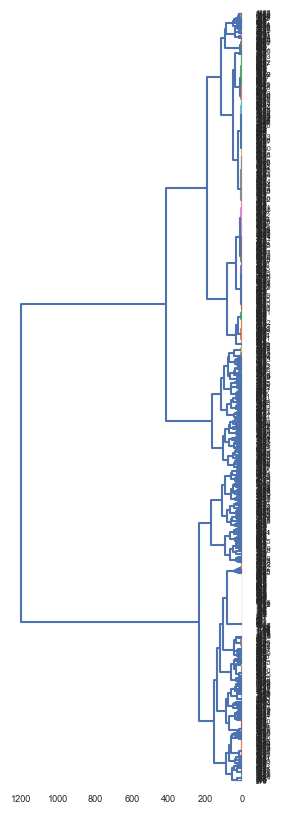

In [57]:
plt.figure(figsize=(3,10))
den = scipy.cluster.hierarchy.dendrogram(heat_clust.dendrogram_row.linkage,
                                         #labels = list(heat_clust.data2d.index),
                                         orientation='left',
                                         color_threshold = 10,
                                         get_leaves = True
                                         )

plt.savefig('den_Heatmap_clustered_filtered_svd_qualite.png', format='png', bbox_inches='tight')
plt.savefig('den_Heatmap_clustered_filtered_svd_qualite.pdf', format='pdf', bbox_inches='tight')

In [276]:
ordered_row_df = heat_clust.data2d
#extract ivl list (order of the dendrogram), leaves_color_list (cluster)
ordered_row_df.insert(0 , "cluster", den["leaves_color_list"])
ordered_row_df.insert(1 ,'order', np.arange(len(ordered_df)))
ordered_row_df.insert(2 , "original_index", den["ivl"])
ordered_row_df.head()

ValueError: cannot insert cluster, already exists

In [277]:
ordered_row_df = ordered_row_df.reset_index()
ordered_row_df['Andersen2005'] = ordered_row_df['Protein IDs'].apply(lambda x: any(i in x for i in Andersen2005['Entry']))
ordered_row_df['SubCellBarcode'] = ordered_row_df['Protein IDs'].apply(lambda x: any(i in x for i in SubCellBarcode[SubCellBarcode['Compartments']=="N3"]['ProteinID']))
ordered_row_df['SubCellBarcode_N'] = ordered_row_df['Protein IDs'].apply(lambda x: any(i in x for i in SubCellBarcode[SubCellBarcode['Compartments'].isin(['N1','N2','N3', 'N4'])]['ProteinID']))
ordered_row_df['Stenstrom2020'] = ordered_row_df['Protein IDs'].apply(lambda x: any(i in x for i in set(Stenstrom2020['Uniprot ID'])))
ordered_row_df = ordered_row_df.set_index('Protein IDs')

In [278]:
ordered_row_df = pd.merge(ordered_row_df, ProteinGroups.set_index('Protein IDs').iloc[:, 0:11], left_index=True, right_index=True)

In [279]:
heat_clust.data2d['cluster'].unique()

array(['C1', 'C2', 'C3', 'C4', 'C5'], dtype=object)

In [280]:
ordered_row_df.to_csv('ordered_row_df_heatmap_wClustering_Total.csv', index=True)

In [287]:
df = ds.mat.T
df = df.T
n = 100
Top_n = anova_df.sort_values(by='ANOVA_pvalue', ascending=True, na_position='last').head(n).index.to_list()

df_TopVariable = df.loc[df.index.isin(Top_n)]
metadata = ds.metadata.set_index("sample")
sample_names = metadata.index.values
group_names = metadata["group"]


pca = sklearn.decomposition.PCA(n_components=5)
components = pca.fit_transform(df)
labels = {
            "0": "PC 1 (%.2f%%)" % (pca.explained_variance_ratio_[0] * 100),
            "1": "PC 2 (%.2f%%)" % (pca.explained_variance_ratio_[1] * 100),
            "2": "PC 3 (%.2f%%)" % (pca.explained_variance_ratio_[2] * 100),
            "3": "PC 4 (%.2f%%)" % (pca.explained_variance_ratio_[3] * 100),
            "4": "PC 5 (%.2f%%)" % (pca.explained_variance_ratio_[4] * 100),
            # "5": "PC 6 (%.2f%%)" % (pca.explained_variance_ratio_[5] * 100),
            # "6": "PC 7 (%.2f%%)" % (pca.explained_variance_ratio_[6] * 100),
            # "7": "PC 8 (%.2f%%)" % (pca.explained_variance_ratio_[7] * 100),
            # "8": "PC 9 (%.2f%%)" % (pca.explained_variance_ratio_[8] * 100),
            # "9": "PC 10 (%.2f%%)" % (pca.explained_variance_ratio_[9] * 100),
    
}

components_df = pd.DataFrame(components, index = ds.metadata[ds.sample])
components_df["sample"] = sample_names
components_df["group"] = group_names
print(components_df.head())
components_df.to_csv("PCA_Proteomics_knn_quantile.csv")

                     0         1         2         3         4        sample  \
sample                                                                         
F_G-FANCI-1  -1.702949  0.192536  0.106972 -0.478038  2.917339   F_G-FANCI-1   
F_G-FANCI-2  -1.623193 -0.652365 -1.983024  3.077980  0.199798   F_G-FANCI-2   
F_G-FANCI-3   0.348316 -2.806961 -0.150012 -1.085826 -0.875854   F_G-FANCI-3   
KSx1-FANCI-1 -3.134601  3.919529  0.874940 -2.992805 -0.694829  KSx1-FANCI-1   
KSx1-FANCI-2 -2.737139  2.005265 -0.267518  2.238129 -2.852721  KSx1-FANCI-2   

                   group  
sample                    
F_G-FANCI-1    F_G_FANCI  
F_G-FANCI-2    F_G_FANCI  
F_G-FANCI-3    F_G_FANCI  
KSx1-FANCI-1  KSx1_FANCI  
KSx1-FANCI-2  KSx1_FANCI  


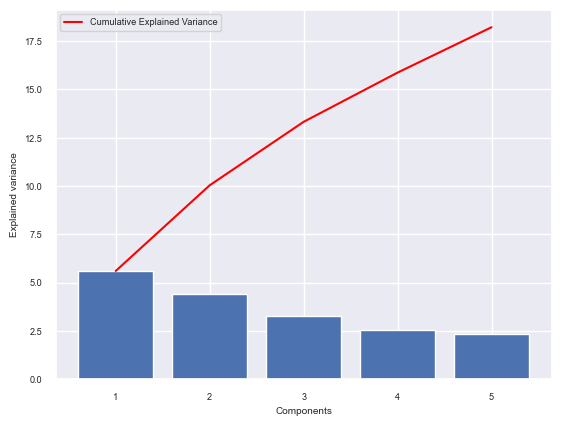

In [288]:
plt.bar(range(1,len(pca.explained_variance_ )+1),pca.explained_variance_ )
plt.ylabel('Explained variance')
plt.xlabel('Components')
plt.plot(range(1,len(pca.explained_variance_ )+1),
         np.cumsum(pca.explained_variance_),
         c='red',
         label="Cumulative Explained Variance")
plt.legend(loc='upper left')


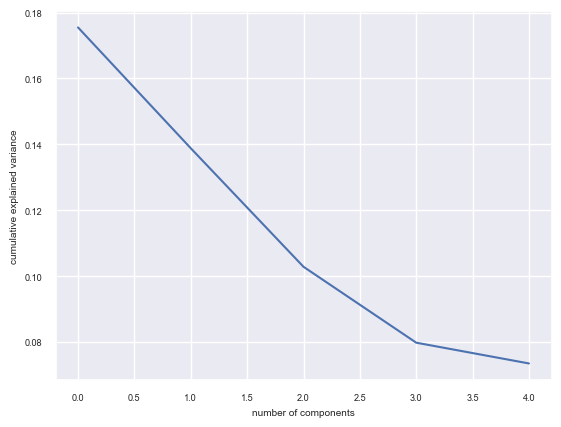

In [289]:
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [290]:
columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5']
loadings = pd.DataFrame(pca.components_.T, columns=columns, index = df.T.index)
loadings.to_csv('components_PCA_svd_qualite.csv', index=True)
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
loadings
loading_matrix = pd.DataFrame(loadings, columns=columns, index = df.T.index)

loading_matrix.to_csv('loading_matrix_PCA_svd_qualite.csv', index=True)
# Get the explained variance ratio
explained_variance =  pd.DataFrame(pca.explained_variance_ratio_, columns=['explained_variance_ratio'], index = columns )
explained_variance.insert(0, "PC", columns)
explained_variance
extracted_col =  ds.metadata["group"].apply(lambda x: x[1])
explained_variance.to_csv('explained_variance_PCA_svd_qualite.csv', index=False)

In [291]:
top_proteins_PC_dict = {}
top_proteins_PC_list = []
n = [5, 10, 20]

# Iterate over each column
for n in n:
    top_proteins_PC_dict = {}
    top_proteins_PC_list = []
    
    for column in loading_matrix.columns:
        # Sort the DataFrame by the current column
        sorted_df_pos = loading_matrix.sort_values(by=column, ascending = False)
        # Get the row names of the first n rows
        row_names_pos = sorted_df_pos.index.tolist()[:n]
        top_proteins_PC_list.append(row_names_pos)
        # Store the row names in the dictionary
        top_proteins_PC_dict[column + "_pos"] = row_names_pos
    
        # Sort the DataFrame by the current column
        sorted_df_neg = loading_matrix.sort_values(by=column, ascending = True)
        # Get the row names of the first n rows
        row_names_neg = sorted_df_neg.index.tolist()[:n]
        top_proteins_PC_list.append(row_names_neg)  
        # Store the row names in the dictionary
        top_proteins_PC_dict[column + "_neg"] = row_names_neg

    top_proteins_PC = pd.DataFrame.from_dict(top_proteins_PC_dict)
    top_proteins_PC.to_csv('top' + str(n) + '_proteins_PC.csv', index=False)
    top_proteins_PC_list = list(reduce(lambda x, y: x + y, top_proteins_PC_list, []))
    top_proteins_PC_list = list(dict.fromkeys(top_proteins_PC_list))
    pd.DataFrame(top_proteins_PC_list, columns = ["Protein IDs"]).to_csv('top' + str(n) + '_proteins_PC_singleList.csv', index=False)
    print("Numer of genes: " + str(len(top_proteins_PC_list)))

Numer of genes: 45
Numer of genes: 89
Numer of genes: 165


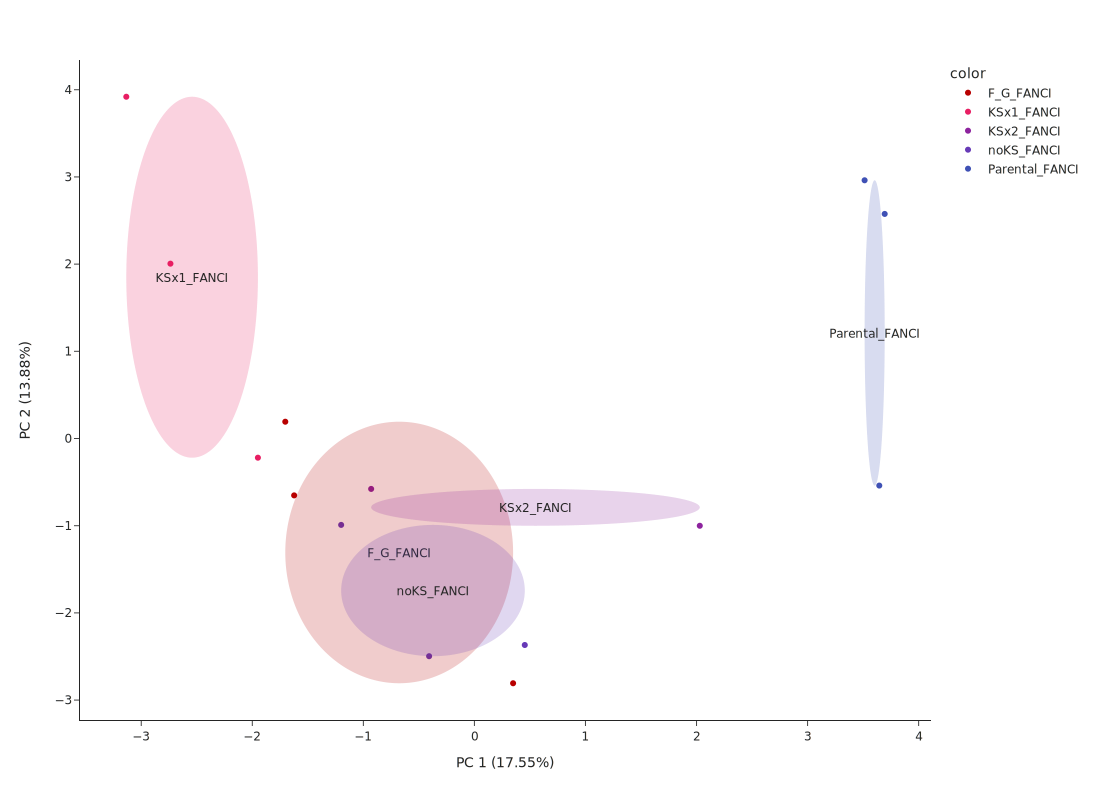

In [292]:
ds.metadata["group"] = ds.metadata["group"].apply(str)


group_color = ds.metadata["group"]
sample_names = ds.metadata[ds.sample]
fig = px.scatter(
    components,
    x=0,
    y=1,
    labels=labels,
    color=group_color,
    template="simple_white+alphastats_colors"
    )

fig_dict = fig.to_plotly_json().get("data")
for group in fig_dict:
    # get coordinates for the group
    x_vector = group.get("x")
    y_vector = group.get("y")
    # get color of the group to color circle in the same color
    group_color = group.get("marker").get("color")
    group_text = group.get("name")
    fig.add_shape(
        type="circle",
        xref="x",
        yref="y",
        x0=min(x_vector),
        y0=min(y_vector),
        x1=max(x_vector),
        y1=max(y_vector),
        opacity=0.2,
        label=dict(text=group_text),
        fillcolor=group_color,
        line_color=group_color,
        )
fig.show(renderer = "svg", width=1100, height=800, equal_axes=True)
fig.write_image("PCA_svd_quantile_PC1_2.pdf")

In [10]:
# KSx1_FANCI_v_noKS_FANCI = ds.diff_expression_analysis(group1 = "KSx1_FANCI", group2 = "noKS_FANCI", column= "group")
# KSx2_FANCI_v_noKS_FANCI = ds.diff_expression_analysis(group1 = "KSx2_FANCI", group2 = "noKS_FANCI", column= "group")
# FG_FANCI_v_noKS_FANCI= ds.diff_expression_analysis(group1 = "F_G_FANCI", group2 = "noKS_FANCI", column= "group")
# KSx1_FANCI_v_KSx2_FANCI= ds.diff_expression_analysis(group1 = "KSx1_FANCI", group2 = "KSx2_FANCI", column= "group")
KSx1_FANCI_v_F_G_FANCI= ds.diff_expression_analysis(group1 = "KSx1_FANCI", group2 = "F_G_FANCI", column= "group")

In [12]:
# KSx1_FANCI_v_noKS_FANCI = pd.merge(KSx1_FANCI_v_noKS_FANCI, ProteinGroups, how="left", left_on="Protein IDs", right_on="Protein IDs")
# KSx2_FANCI_v_noKS_FANCI = pd.merge(KSx2_FANCI_v_noKS_FANCI, ProteinGroups, how="left", left_on="Protein IDs", right_on="Protein IDs")
# FG_FANCI_v_noKS_FANCI = pd.merge(FG_FANCI_v_noKS_FANCI, ProteinGroups, how="left", left_on="Protein IDs", right_on="Protein IDs")
# KSx1_FANCI_v_KSx2_FANCI = pd.merge(KSx1_FANCI_v_KSx2_FANCI, ProteinGroups, how="left", left_on="Protein IDs", right_on="Protein IDs")
KSx1_FANCI_v_F_G_FANCI = pd.merge(KSx1_FANCI_v_F_G_FANCI, ProteinGroups, how="left", left_on="Protein IDs", right_on="Protein IDs")
df = ds.mat.T.reset_index()

# KSx1_FANCI_v_noKS_FANCI = pd.merge(KSx1_FANCI_v_noKS_FANCI, df, how="left", left_on="Protein IDs", right_on="Protein IDs")
# KSx2_FANCI_v_noKS_FANCI = pd.merge(KSx2_FANCI_v_noKS_FANCI, df, how="left", left_on="Protein IDs", right_on="Protein IDs")
# FG_FANCI_v_noKS_FANCI = pd.merge(FG_FANCI_v_noKS_FANCI, df, how="left", left_on="Protein IDs", right_on="Protein IDs")
# KSx1_FANCI_v_KSx2_FANCI = pd.merge(KSx1_FANCI_v_KSx2_FANCI, df, how="left", left_on="Protein IDs", right_on="Protein IDs")
KSx1_FANCI_v_F_G_FANCI = pd.merge(KSx1_FANCI_v_F_G_FANCI, df, how="left", left_on="Protein IDs", right_on="Protein IDs")

In [13]:
DF_list = {
    # "KSx1_FANCI_v_noKS_FANCI" : KSx1_FANCI_v_noKS_FANCI,
    #        "KSx2_FANCI_v_noKS_FANCI" : KSx2_FANCI_v_noKS_FANCI,
    #        "FG_FANCI_v_noKS_FANCI" : FG_FANCI_v_noKS_FANCI,
    #        "KSx1_FANCI_v_KSx2_FANCI": KSx1_FANCI_v_KSx2_FANCI,
    "KSx1_FANCI_v_F_G_FANCI": KSx1_FANCI_v_F_G_FANCI
           
           
}

In [85]:
df

,Protein IDs,F_G-FANCI-1,F_G-FANCI-2,F_G-FANCI-3,F_G-FANCI-4,KSx1-FANCI-1,KSx1-FANCI-2,KSx1-FANCI-3,KSx2-FANCI-2,KSx2-FANCI-3,noKS-FANCI-1,noKS-FANCI-2,noKS-FANCI-3,noKS-FANCI-4,Parental-FANCI-1,Parental-FANCI-2,Parental-FANCI-3,Parental-FANCI-4
0,Q9Y2S6;A0A024R1R8,0.000000,14.995988,15.129726,15.115166,0.000000,14.689507,15.058499,0.000000,15.134827,15.223398,15.595607,15.819106,16.362680,15.351077,0.000000,0.000000,15.384447
1,A0MZ66;A0MZ66-3;A0MZ66-4;A0MZ66-5;A0MZ66-6;A0M...,13.482682,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,13.876037,13.981032,0.000000,0.000000,0.000000,12.764021,0.000000,0.000000,0.000000,0.000000
2,P62308;A8MWD9,0.000000,0.000000,14.935764,0.000000,0.000000,0.000000,0.000000,15.682748,0.000000,0.000000,0.000000,0.000000,14.602467,0.000000,0.000000,0.000000,15.010397
3,E9PAV3;Q13765;E9PAV3-2,14.741046,14.573055,15.117968,15.169651,15.501993,15.411577,15.235042,15.907806,15.686501,14.888172,15.432118,15.223587,15.735741,14.688414,15.296414,15.126099,15.306204
4,E9PRG8,16.156063,15.819880,16.318472,16.424216,16.522536,16.137031,15.744650,16.044181,15.853163,16.334256,16.366288,15.884767,16.479891,15.689425,15.875077,15.722594,15.968892
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1328,Q9Y5J1,16.880468,17.257185,17.033488,16.980363,17.024642,17.402746,17.100621,17.149172,17.004923,17.049104,17.208387,16.873636,16.895812,16.293166,16.777641,16.471723,16.892614
1329,Q9Y5Q9;Q9Y5Q9-2,14.512308,14.771747,14.731584,14.414553,0.000000,14.872915,14.418182,14.684639,14.697619,14.529980,14.357140,13.997268,14.104107,0.000000,14.295338,14.352595,14.702010
1330,Q9Y5S9;Q9Y5S9-2,16.249595,16.175822,16.676728,16.726671,15.956966,15.999582,16.181366,17.128981,16.970735,16.419104,16.341936,16.552384,17.215040,16.714111,17.095170,17.025507,17.335687
1331,Q9Y6V7,17.949576,18.061023,17.900242,17.826685,17.867315,17.996893,18.080047,17.515068,17.818158,17.721807,18.006731,18.028694,17.388101,17.765260,17.787431,17.644560,17.578063


In [90]:
top_n_down = df[df["Protein IDs"].isin(List_genes)]

In [91]:
top_n_down

,Protein IDs,F_G-FANCI-1,F_G-FANCI-2,F_G-FANCI-3,F_G-FANCI-4,KSx1-FANCI-1,KSx1-FANCI-2,KSx1-FANCI-3,KSx2-FANCI-2,KSx2-FANCI-3,noKS-FANCI-1,noKS-FANCI-2,noKS-FANCI-3,noKS-FANCI-4,Parental-FANCI-1,Parental-FANCI-2,Parental-FANCI-3,Parental-FANCI-4
8,msfGFP-NPM1;P06748;P06748-2;P06748-3,20.961693,21.217563,21.145382,21.093069,21.320144,21.262586,21.038185,20.765794,20.667697,21.325314,21.215313,21.081023,21.284553,20.569874,20.797250,20.577178,20.654559
106,O75683,18.199308,17.988319,18.199500,18.179423,18.388942,18.242700,17.967136,18.180201,17.844877,18.201942,18.173628,18.096972,18.295356,17.689002,17.750550,17.772753,17.544949
625,Q07020;Q07020-2,16.874357,16.954355,16.122585,16.647936,17.000968,16.900655,16.843406,17.136511,16.553569,17.162313,17.112786,17.016068,17.497010,16.866289,16.750419,16.525781,16.199653
813,Q6NW34;Q6NW34-2,14.024101,14.119103,13.866313,13.913263,0.000000,0.000000,0.000000,13.225509,0.000000,13.764042,14.109504,13.881114,13.557703,13.585432,13.756035,13.100432,13.592223


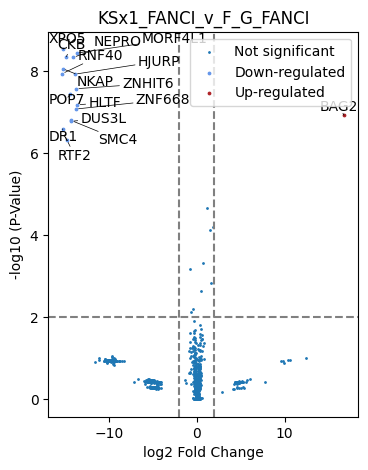

In [14]:
from adjustText import adjust_text
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['pdf.fonttype'] = 42

for key, value in DF_list.items():
    df = DF_list[key]

    df.to_csv(key + '_t-test_diffExp.csv', index=False)

    plt.subplots(figsize=(4, 5))
    top_n = 20
    
    plt.scatter(x=df['log2fc'],y=df['pval'].apply(lambda x:-np.log10(x)),s=1,label="Not significant")
    
    # highlight down- or up- regulated genes
    down = df[(df['log2fc']<=-2)&(df['pval']<=0.01)]
    up = df[(df['log2fc']>=2)&(df['pval']<=0.01)]

    with open('down'+key+'.txt', 'w') as f:
        for genes in down['Gene names']:
            f.write("%s\n" % genes)

    with open('Up'+key+'.txt', 'w') as f:
        for genes in up['Gene names']:
            f.write("%s\n" % genes)

    List_genes = ['msfGFP-NPM1;P06748;P06748-2;P06748-3',
                  'Q6NW34;Q6NW34-2', #NEPRO
              'O75683', #SURF6
              'Q07020;Q07020-2' #RPL18
                 ]
    
    top_n_up = up.sort_values(by=['log2fc', 'pval'], ascending=[False, True]).head(top_n)
    top_n_down = down.sort_values(by=['log2fc', 'pval'], ascending=[False, True]).tail(top_n)

    
    plt.scatter(x=down['log2fc'],y=down['pval'].apply(lambda x:-np.log10(x)),s=3,label="Down-regulated",color="#6697EA")
    plt.scatter(x=up['log2fc'],y=up['pval'].apply(lambda x:-np.log10(x)),s=3,label="Up-regulated",color="#B02428")
    
    texts=[]
    for i,r in top_n_up.iterrows():
        texts.append(plt.text(x=r['log2fc'],y=-np.log10(r['pval']),s=r['Gene names']))
    
    for i,r in top_n_down.iterrows():
        texts.append(plt.text(x=r['log2fc'],y=-np.log10(r['pval']),s=r['Gene names']))
    adjust_text(texts,arrowprops=dict(arrowstyle="-", color='black', lw=0.5))
    
    plt.title(key)
    plt.style.use('seaborn-v0_8-colorblind')
    plt.xlabel("log2 Fold Change")
    plt.ylabel("-log10 (P-Value)")
    plt.axvline(-2,color="grey",linestyle="--")
    plt.axvline(2,color="grey",linestyle="--")
    plt.axhline(2,color="grey",linestyle="--")
    plt.legend()
    plt.savefig(key + '_t-test_volcanoplot.pdf')

In [84]:
top_n_up

,Protein IDs,pval,log2fc,Majority protein IDs,Peptide counts (all),Peptide counts (razor+unique),Peptide counts (unique),Protein names,Gene names,Fasta headers,...,KSx2-FANCI-2,KSx2-FANCI-3,noKS-FANCI-1,noKS-FANCI-2,noKS-FANCI-3,noKS-FANCI-4,Parental-FANCI-1,Parental-FANCI-2,Parental-FANCI-3,Parental-FANCI-4
1000,Q96JN0-3;Q96JN0;Q96JN0-2,0.020879,10.272542,Q96JN0-3,7;3;3,7;3;3,7;3;3,Ligand-dependent corepressor,LCOR,sp|Q96JN0-3|LCOR_HUMAN Isoform 3 of Ligand-dep...,...,0.000000,13.701523,0.000000,0.000000,0.000000,13.212907,13.586605,0.000000,0.000000,13.755201
169,P05141;Q9H0C2,0.026280,10.228478,P05141,9;3,2;0,2;0,"ADP/ATP translocase 2;ADP/ATP translocase 2, N...",SLC25A5,sp|P05141|ADT2_HUMAN ADP/ATP translocase 2 OS=...,...,0.000000,0.000000,0.000000,13.955559,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
577,P78527;P78527-2,0.002441,0.568696,P78527;P78527-2,38;37,38;37,38;37,DNA-dependent protein kinase catalytic subunit,PRKDC,sp|P78527|PRKDC_HUMAN DNA-dependent protein ki...,...,16.784942,16.720405,16.108382,16.308872,16.443364,15.938890,16.763964,16.786857,16.758510,16.791443
821,Q6PCB5;Q6PCB5-2,0.008961,0.548069,Q6PCB5,14;5,14;5,14;5,Lysine-specific demethylase RSBN1L,RSBN1L,sp|Q6PCB5|RSBNL_HUMAN Lysine-specific demethyl...,...,14.807808,15.186114,14.880875,14.679975,15.109504,14.695663,15.284210,15.052483,15.036345,15.065374


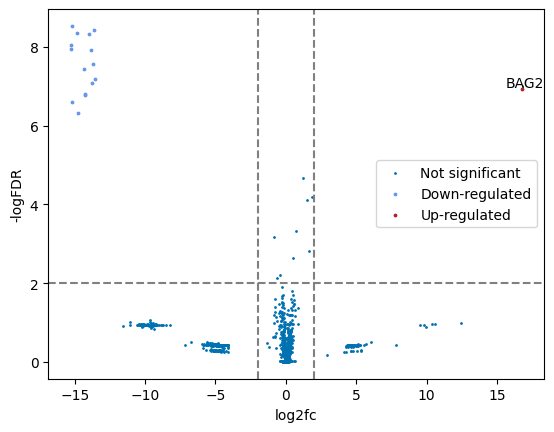

In [15]:

from adjustText import adjust_text
df = KSx1_FANCI_v_F_G_FANCI
df = df.set_index("Gene names")

plt.scatter(x=df['log2fc'],y=df['pval'].apply(lambda x:-np.log10(x)),s=1,label="Not significant")

# highlight down- or up- regulated genes
down = df[(df['log2fc']<=-2)&(df['pval']<=0.01)]
up = df[(df['log2fc']>=2)&(df['pval']<=0.01)]

plt.scatter(x=down['log2fc'],y=down['pval'].apply(lambda x:-np.log10(x)),s=3,label="Down-regulated",color="#6697EA")
plt.scatter(x=up['log2fc'],y=up['pval'].apply(lambda x:-np.log10(x)),s=3,label="Up-regulated",color="#B02428")
texts=[]
for i,r in up.iterrows():
    texts.append(plt.text(x=r['log2fc'],y=-np.log10(r['pval']),s=i))
adjust_text(texts,arrowprops=dict(arrowstyle="-", color='black', lw=0.5))
plt.xlabel("log2fc")
plt.ylabel("-logFDR")
plt.axvline(-2,color="grey",linestyle="--")
plt.axvline(2,color="grey",linestyle="--")
plt.axhline(2,color="grey",linestyle="--")
plt.legend()